# Lugge glacier 2D 

This notebook uses the RGI outline to mesh Lugge Glacier, and then interpolates several datasets onto the mesh (elevation, thickness, surface mass balance).  

## Imports

In [1]:
import icepack, icepack.plot, icepack.meshing
from firedrake import *
import geopandas as gpd
import geojson
from geojson.utils import coords
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import pandas as pd
import rasterio
from scipy.interpolate import griddata, interp1d
from shapely.geometry import shape, Polygon, MultiPolygon, LineString

## Set paths

In [2]:
base_path = '/eejit/home/bezu0001/'
shapefile_path = base_path + 'data/outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
dem_path = base_path + 'data/elevation/DEM-SRTMv3/SRTMv3_RGI60-15-02373.tif'
thickness_path = base_path + 'data/bed/Thickness-Farinotti/RGI60-15-02373_latlon.tif'
smb_path = base_path + 'data/smb/prf_glacier_ctl.csv'
mesh_path = base_path + 'icepack/meshes/'

## RGI outline

[Text(0.5, 0, 'longitude'),
 Text(0, 0.5, 'latitude'),
 (90.285653, 90.351478),
 (28.079113999999997, 28.166978)]

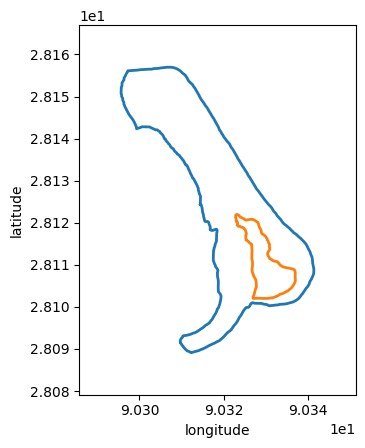

In [3]:
regional_outlines = gpd.read_file(shapefile_path)
lugge_gdf = regional_outlines[regional_outlines['rgi_id'].str.contains("15-09534")]
lugge_geojson = geojson.loads(lugge_gdf.to_json())

# Calculate bounding box with small buffer
δ = 0.01
coords_array = np.array(list(coords(lugge_geojson)))
xmin, xmax = coords_array[:, 0].min() - δ, coords_array[:, 0].max() + δ
ymin, ymax = coords_array[:, 1].min() - δ, coords_array[:, 1].max() + δ

# Plot outline
fig, ax = icepack.plot.subplots()

for feature in lugge_geojson["features"]:
    geometry = feature["geometry"]
    rings = geometry["coordinates"] if geometry["type"] == "Polygon" else [ring for poly in geometry["coordinates"] for ring in poly]
    for ring in rings:
        xs = np.array(ring)
        ax.plot(xs[:, 0], xs[:, 1], linewidth=2)

ax.set(xlabel="longitude", ylabel="latitude", xlim=(xmin, xmax), ylim=(ymin, ymax))

## Split boundary up into subdomains

With the goal of ultimately running a flow model, we need to have different boundaries for imposing boundary conditions. We can do this by slicing the boundary up into segments of 50 points each. First, identify which parts of the outline are exterior, and which are interior, and split up the exterior boundary into segments 50 points long:

In [4]:
# Initialize lists to hold boundaries and holes
exterior_lines = []
interior_rings = []

for feature in lugge_geojson["features"]:
    geom = shape(feature["geometry"])
    # Handle both Polygon and MultiPolygon uniformly
    polys = [geom] if isinstance(geom, Polygon) else geom.geoms
    for poly in polys:
        exterior_lines.append(LineString(poly.exterior.coords))
        interior_rings.extend([LineString(ring) for ring in poly.interiors])

print(f"Extracted {len(exterior_lines)} exterior boundary line(s)")
print(f"Extracted {len(interior_rings)} interior hole(s)")

N = 50  # Number of points per segment (adjust as needed)
segments = []

for idx, line in enumerate(exterior_lines):
    coords = list(line.coords)
    for i in range(0, len(coords), N):
        segment_coords = coords[i:i+N]
        if len(segment_coords) > 1:  # Make sure the segment is valid
            segment = LineString(segment_coords)
            segments.append((f"segment_{idx}_{i}", segment))  # Assign a unique ID


Extracted 1 exterior boundary line(s)
Extracted 1 interior hole(s)


## Now create a dataframe object out of the external segments:

In [5]:
# Create a DataFrame with segment geometries and IDs
segment_df = pd.DataFrame({
    "id": [seg_id for seg_id, seg_geom in segments],
    "geometry": [seg_geom for seg_id, seg_geom in segments]
})

# Convert to GeoDataFrame, preserving CRS
lugge_segments_gdf = gpd.GeoDataFrame(segment_df, geometry="geometry", crs=lugge_gdf.crs)

print(f"Created GeoDataFrame with {len(lugge_segments_gdf)} features.")

Created GeoDataFrame with 10 features.


## And add the interior hole to the dataframe:

In [6]:
# Create a GeoDataFrame for the interior holes
holes_df = pd.DataFrame({
    "id": [f"hole_{i}" for i in range(len(interior_rings))],
    "geometry": interior_rings
})

# Convert to GeoDataFrame, preserving CRS
holes_gdf = gpd.GeoDataFrame(holes_df, geometry="geometry", crs=lugge_gdf.crs)

# Combine with the split exterior segments
full_gdf = pd.concat([lugge_segments_gdf, holes_gdf], ignore_index=True)

print(f"Combined GeoDataFrame has {len(full_gdf)} features.")

Combined GeoDataFrame has 11 features.


# Mesh the result, and plot

In [7]:
# Convert full_gdf to GeoJSON FeatureCollection
full_geojson = geojson.loads(full_gdf.to_json())

# Now pass this to collection_to_gmsh
gmsh_mesh = icepack.meshing.collection_to_gmsh(full_geojson)
gmsh_mesh.write(mesh_path + 'lugge.msh', verbose=False)
mesh = firedrake.Mesh(mesh_path + 'lugge.msh')
mesh_path += 'lugge.msh'

PETSc Error --- Application was linked against both OpenMPI and MPICH based MPI libraries and will not run correctly


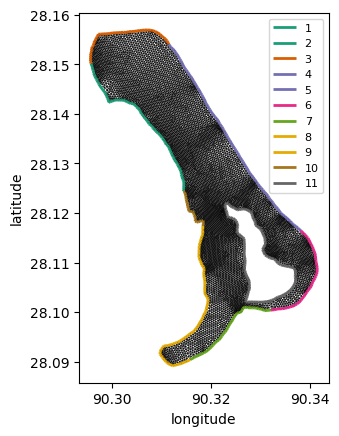

In [8]:
# Create the plot
fig, axes = plt.subplots()
axes.set_xlabel("longitude")
axes.set_ylabel("latitude")

kwargs = {
    "interior_kw": {"linewidth": 0.25},   # Thin lines for interior edges
    "boundary_kw": {"linewidth": 2},      # Thicker lines for boundary segments
}
triplot(mesh, axes=axes, **kwargs)

axes.set_aspect('equal')  # Ensure equal aspect ratio
axes.legend(loc="upper right", fontsize = 8)
plt.show()

## DEM

<Figure size 800x600 with 0 Axes>

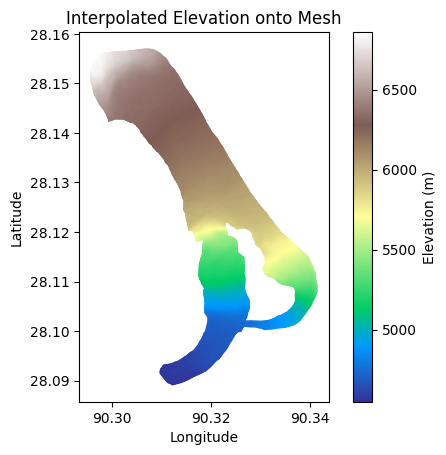

In [9]:
# Load DEM
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)
    dem_data = np.where(dem_data == src.nodata, np.nan, dem_data)
    transform = src.transform
    rows, cols = np.indices(dem_data.shape)
    lons, lats = rasterio.transform.xy(transform, rows, cols, offset='center')
    points = np.column_stack((np.array(lons).flatten(), np.array(lats).flatten()))
    values = dem_data.flatten()

# Load Mesh
mesh = Mesh(mesh_path)
vertex_coords = np.array(mesh.coordinates.dat.data_ro)

# Interpolate
elevations = griddata(points, values, vertex_coords, method='linear', fill_value=np.nan)

# Assign to Firedrake Function
V = FunctionSpace(mesh, "CG", 1)
elevation_function = Function(V)
elevation_function.dat.data[:] = elevations

# Plot
plt.figure(figsize=(8, 6))
tpc = tripcolor(elevation_function, cmap='terrain')
plt.title("Interpolated Elevation onto Mesh")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(tpc, label="Elevation (m)")
plt.gca().set_aspect('equal')  # Maintain equal aspect ratio
plt.show()

## Thickness/bed data

<Figure size 800x600 with 0 Axes>

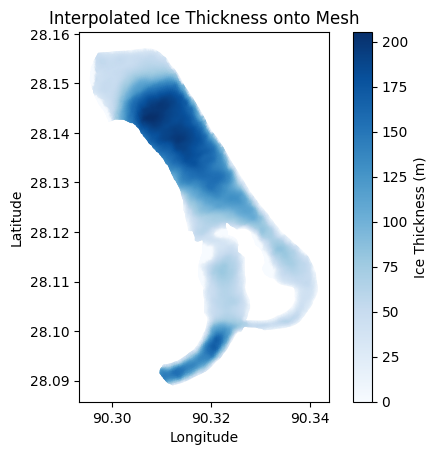

In [10]:
# Load Thickness Raster
with rasterio.open(thickness_path) as src:
    thickness_data = src.read(1)
    thickness_data = np.where(thickness_data == src.nodata, np.nan, thickness_data)
    transform = src.transform
    rows, cols = np.indices(thickness_data.shape)
    lons, lats = rasterio.transform.xy(transform, rows, cols, offset='center')
    points = np.column_stack((np.array(lons).flatten(), np.array(lats).flatten()))
    values = thickness_data.flatten()

# Load Mesh
mesh = Mesh(mesh_path)
vertex_coords = np.array(mesh.coordinates.dat.data_ro)

# Interpolate
thickness = griddata(points, values, vertex_coords, method='linear', fill_value=np.nan)

# Assign to Firedrake Function
V = FunctionSpace(mesh, "CG", 1)
thickness_function = Function(V)
thickness_function.dat.data[:] = thickness

# Plot
plt.figure(figsize=(8, 6))
tpc = tripcolor(thickness_function, cmap='Blues')  # Blues colormap for thickness
plt.title("Interpolated Ice Thickness onto Mesh")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(tpc, label="Ice Thickness (m)")
plt.gca().set_aspect('equal')
plt.show()

## Surface mass balance

<Figure size 800x600 with 0 Axes>

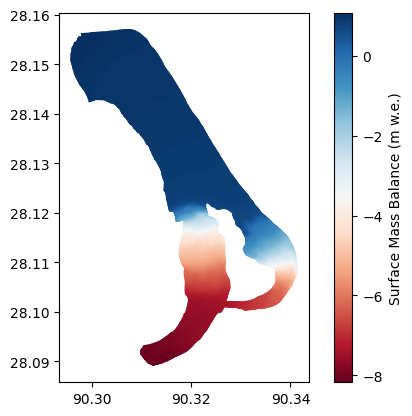

In [11]:
# Load data
df = pd.read_csv(smb_path)
interp_mb = interp1d(df[' altitude'].values, df['ave_mb'].values, bounds_error=False, fill_value=np.nan)
mesh_mb = interp_mb(elevation_function.dat.data_ro)

# Interpolate SMB onto mesh
V = FunctionSpace(mesh, "CG", 1)
smb_function = Function(V)
smb_function.dat.data[:] = mesh_mb

# Plot
plt.figure(figsize=(8, 6))
tpc = tripcolor(smb_function, cmap='RdBu', shading='gouraud')
plt.colorbar(tpc, label="Surface Mass Balance (m w.e.)")
plt.gca().set_aspect('equal')
plt.show()